---
title: "Makemore activations & gradients, BatchNorm"
format: 
    gfm:
        echo: false
jupyter: python3
---

In this post, I dig deeper into the activations & gradients of the multi layer perceptron that we built in [the previous exercise](../003_makemore_mlp).

The goal is to improve the loss of the model by optimizing the initialization and structure of the network.

The work in this post is based on [this lecture](https://www.youtube.com/watch?v=P6sfmUTpUmc).

## Preparing datasets 

Let's start by reading in an input list of words and preparing our training, dev, test datasets.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import random
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchviz import make_dot
pp = pprint.PrettyPrinter()

g = torch.Generator().manual_seed(0)

%matplotlib inline

In [14]:
#| echo: true
filename = 'names.txt'

def get_names():
    names = []
    for line in open(filename, 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name or not name.isalpha:
            continue
        names.append(name)
    return names

words = get_names()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


Then, we write some helpers to convert between letters and numerical indexes.

In [15]:
#| echo: true
letters = '.' + ''.join(sorted(set(''.join(words))))
num_letters = len(letters)

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}

print(letters)

.abcdefghijklmnopqrstuvwxyz


And a helper function to turn words into tensors.

In [16]:
#| echo: true
context_size = 3 # how many letters do we see to predict the next one

def build_dataset(words):
    X, Y = [], []
    for word in words:
        # takes advantage of the fact itos[0] == '.'
        context = [0] * context_size

        for ch in word + '.':
            X.append(context)
            ix = ltoi[ch]
            Y.append(ix)

            context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

# sanity check the function
xx, yy = build_dataset(['emma'])
pp.pprint(list(zip(xx, yy)))

[(tensor([0, 0, 0]), tensor(5)),
 (tensor([0, 0, 5]), tensor(13)),
 (tensor([ 0,  5, 13]), tensor(13)),
 (tensor([ 5, 13, 13]), tensor(1)),
 (tensor([13, 13,  1]), tensor(0))]


Let's now prepare the training, dev and test datasets.

- Training - 80% of our data. Used to train the model
- Dev - 10% of our data. Used to evaluate the model, to verify that the model isn't overfitting and to tune hyperparameters.
- Test - 10% of our data. Used to check that the model is going to work on never before seen data.

In [17]:
#| echo: true
import random

random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

In [18]:
#| echo: true
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

print("train shape", Xtr.shape)
print("dev shape", Xdev.shape)
print("test shape", Xtest.shape)

assert Xtr.shape[0], Ytr.shape[0]
assert Xtr.dtype == Ytr.dtype == torch.int64

train shape torch.Size([182625, 3])
dev shape torch.Size([22655, 3])
test shape torch.Size([22866, 3])


Our datasets are ready.

## Neural network setup 

Let's train the multi layer perceptron and evaluate the network.

In [27]:
#| echo: true
#| output: false
batch_size = 32

# changed these parameters 10 times to achieve the best loss on the dev set
training_iter = 200000
word_embedding_size = 64
hidden_layer_size = 64

class MLPBase:
    """MLPBase is the base class for all the multi layer perceptron
    models we'll try in this post to optimize our network"""

    def __init__(self):
        # C maps each letter to its embedding
        self.C = torch.randn((num_letters, word_embedding_size), generator=g)

        # W1, B1 are parameters for the embedding layer -> hidden layer
        self.W1 = torch.randn((context_size * word_embedding_size, hidden_layer_size), generator=g)
        self.B1 = torch.randn((hidden_layer_size,), generator=g)

        # W2, B2 are parameters for the hidden layer -> output layer
        self.W2 = torch.randn((hidden_layer_size, num_letters), requires_grad=True, generator=g)
        self.B2 = torch.randn((num_letters,), generator=g)

        self.params = [self.C, self.W1, self.B1, self.W2, self.B2,]
        self.named_params = {
            'C': self.C,
            'W1': self.W1, 
            'B1': self.B1,
            'W2': self.W2,
            'B2': self.B2,
        }

        for param in self.params:
            param.requires_grad = True

        self.last_H = None
        self.last_logits = None

    def __call__(self, X: torch.Tensor, training=False):
        # E is the embedding layer
        # the shape of this is num_examples * context_size * word_embedding_size
        E = self.C[X].view(-1, context_size * word_embedding_size) 

        # H is the hidden layer
        H = (E @ self.W1 + self.B1).tanh()
        self.last_H = H

        # logits from the output layer
        logits = H @ self.W2 + self.B2
        self.last_logits = logits
        return logits
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def optim_step(self, lr: float):
        for param in self.params:
            param.data += -lr * param.grad

    def weight_decay_value(self, c: float): # this is the regularization term
        return c * ((self.W1 ** 2).mean() + (self.W2 ** 2).mean())


Visually, this network looks like this:

```{dot}

digraph {
	node [align=left fontname=monospace fontsize=10 height=0.2 ranksep=0.1 shape=box style=filled]
	Logits [label="Logits
 (32, 27)" fillcolor=darkolivegreen1]
	Add2 [label="Add \n (32, 27)"]
	MatMul2 -> Add2
	MatMul2 [label="MatMul \n (32, 27)"]
	Tanh -> MatMul2
	Tanh [label="Tanh \n (32, 64)"]
	Add -> Tanh
	Add [label="Add \n(32, 64)"]
	MatMul -> Add
	MatMul [label="MatMul\n (32, 64)"]
	View -> MatMul
	View [label="View\n (32, 192)"]
	Index -> View
	Index [label="Index\n (32, 3, 64)"]
	X [label="X
(32, 3)" fillcolor=gold1]
	C [label="C
(27, 64)" fillcolor=lightblue]
	C -> Index 
	X -> Index 
	W1 -> MatMul
	W1 [label="W1
 (192, 64)" fillcolor=lightblue]
	B1 [label="B1
 (64)" fillcolor=lightblue]
	B1 -> Add
	W2 [label="W2
 (64, 27)" fillcolor=lightblue]
	W2 -> MatMul2
	B2 [label="B2
 (27)" fillcolor=lightblue]
	B2 -> Add2
	Add2 -> Logits
}
```

In [150]:
#| echo: true
#| output: false

def train_model(model, n_iter=training_iter):
    training_losses = []

    for i in tqdm(range(n_iter)):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        X = Xtr[ix]
        Y = Ytr[ix]

        O = model(X, training=True)
        loss = F.cross_entropy(O, Y) + model.weight_decay_value(0.1)

        model.zero_grad()
        loss.backward()

        lr = 0.1 if i < training_iter // 2 else 0.01
        model.optim_step(lr)
        training_losses.append(loss.data)
    return training_losses

def eval_model(model):
    return F.cross_entropy(model(Xdev), Ydev).data.item()

100%|██████████| 200000/200000 [00:56<00:00, 3527.51it/s]


2.183145046234131


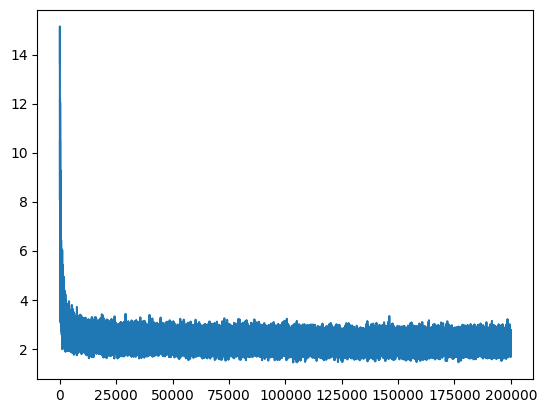

In [151]:
base = MLPBase()
training_losses = train_model(base)
dev_loss = eval_model(base)

print(dev_loss)
plt.plot(training_losses);

The base model gives us a dev loss of ~2.18. It's a multi layer perceptron where the weights are initialized using a random gaussian.

Let's see how we can make this better. The first thing we see is that there's a hockey stick drop in the loss at the very beginning of training.

In [152]:
base = MLPBase()
training_losses = train_model(base, n_iter=1)

print(training_losses[0])

100%|██████████| 1/1 [00:00<00:00, 1081.28it/s]

tensor(16.4445)


This hockey stick drop in the loss happens because upon initialization, the loss of this network is really high. The initial logits are randomly favoring one character over another.

We want our network to think that all letters are roughly equally likely at the beginning, and we want the logits to be roughly uniform. 

This way we don't waste iterations because we randomly assumed that one letter is favored over another.

Let's make this change and see how well it works.

In [153]:
#| echo: true
#| output: false
class MLPReduceInitialLoss(MLPBase):
    """In MLPReduceInitialLoss, we'll initialize our network to have
    a lower initial loss

    We'll do this by scaling the initial weights"""

    def __init__(self):
        super().__init__()

        # we scale the hidden layer weights by 0.01 to avoid large logit values initially
        # we initialize our bias to 0

        self.W2 = torch.randn((hidden_layer_size, num_letters)) * 0.01
        self.B2 = torch.randn((num_letters)) * 0

        self.params = [self.C, self.W1, self.B1, self.W2, self.B2]

        for param in self.params:
            param.requires_grad = True


In [154]:
reduce_initial_loss = MLPReduceInitialLoss()
train_losses = train_model(reduce_initial_loss, n_iter=1)

print(train_losses[0])

100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]

tensor(3.3927)


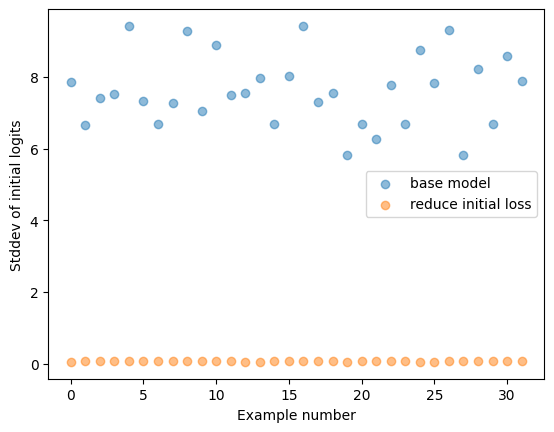

In [155]:
fig, ax = plt.subplots(1, 1)

std_base = base.last_logits.data.std(axis=1)
std_reduce_initial = reduce_initial_loss.last_logits.data.std(axis=1)

x = torch.arange(base.last_logits.data.shape[0])

ax.scatter(x, std_base, alpha=0.5, label='base model')
ax.scatter(x, std_reduce_initial, alpha=0.5, label='reduce initial loss')

ax.set_ylabel('Stddev of initial logits')
ax.set_xlabel('Example number')

ax.legend()

Now, our probabilities are a lot closer to uniform and our initial loss is a lot closer to $-\log \frac{1}{27}$.

Let's see if this improves the model when trained for 200k iterations.

The dev loss we are trying to beat is ~2.18.

100%|██████████| 200000/200000 [00:53<00:00, 3729.61it/s]


tensor(2.1788)


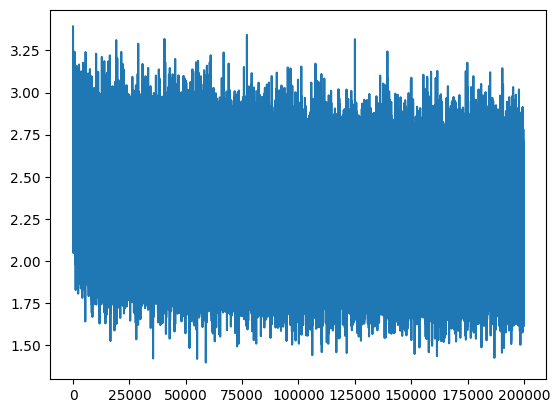

In [95]:
reduce_initial_loss = MLPReduceInitialLoss()
train_losses = train_model(reduce_initial_loss)

dev_loss = eval_model(reduce_initial_loss)
print(dev_loss.data)
plt.plot(train_losses);

In the lecture, the next thing Karpathy does is look at the activations for the tanh layer to make sure that the tanh neuron is not saturated.

100%|██████████| 1/1 [00:00<00:00, 275.72it/s]


Text(0.5, 1.0, 'black = >0.99, white = <0.99')

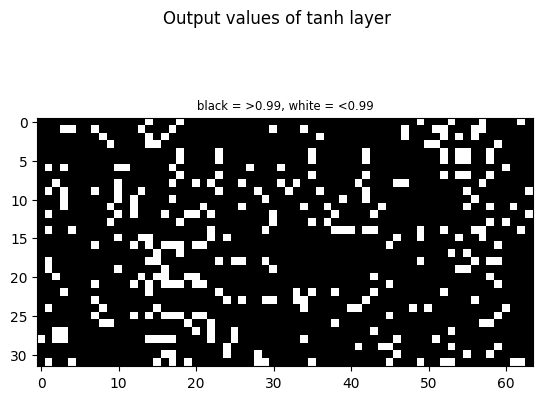

In [131]:
reduce_initial_loss = MLPReduceInitialLoss()
train_losses = train_model(reduce_initial_loss, n_iter=1)

h = reduce_initial_loss.last_H.data

plt.imshow(h.abs() > 0.99, cmap='Greys');
plt.suptitle('Output values of tanh layer')
plt.title('black = >0.99, white = <0.99', fontsize='small')

Text(0.5, 1.0, 'Output values of tanh layer (histogram)')

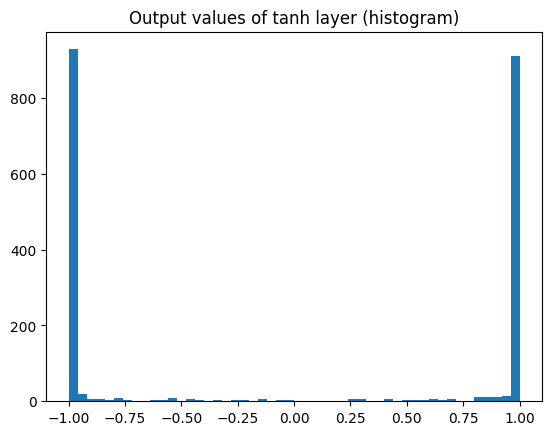

In [132]:
plt.hist(h.view(-1), bins=50);
plt.title('Output values of tanh layer (histogram)')

The distribution of tanh outputs looks saturated here. This is because tanh is a squashing function.

When the outputs of tanh are this large, it means that the weights of the layer going into the tanh must be too large.

Let's fix this.

In [133]:
#| echo: true
#| output: false
class MLPReduceTanhSaturation(MLPReduceInitialLoss):
    """In MLPReduceTanhSaturation, we'll fix the saturation of the tanh
    layer by scaling the initial weights of the layer going into the hidden
    layer"""

    def __init__(self):
        super().__init__()

        # W1, B1 are parameters for the embedding layer -> hidden layer
        self.W1 = torch.randn((context_size * word_embedding_size, hidden_layer_size), generator=g) * 0.1
        self.B1 = torch.randn((hidden_layer_size,), generator=g) * 0.01

        self.params = [self.C, self.W1, self.B1, self.W2, self.B2]

        for param in self.params:
            param.requires_grad = True

100%|██████████| 1/1 [00:00<00:00, 1122.37it/s]


Text(0.5, 0.9, 'black = >0.99, white = <0.99')

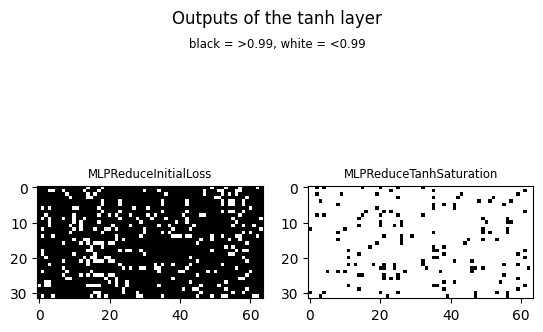

In [135]:
reduce_tanh_sat = MLPReduceTanhSaturation()

training_losses = train_model(reduce_tanh_sat, n_iter=1)
before_h = reduce_initial_loss.last_H.data
after_h = reduce_tanh_sat.last_H.data

fig, axs = plt.subplots(1, 2)

axs[0].imshow(before_h.abs() > 0.99, cmap='Greys')
axs[0].set_title('MLPReduceInitialLoss', fontsize='small')
axs[1].imshow(after_h.abs() > 0.99, cmap='Greys')
axs[1].set_title('MLPReduceTanhSaturation', fontsize='small')

fig.suptitle('Outputs of the tanh layer')
fig.text(x=0.5, y=0.9, s='black = >0.99, white = <0.99', ha='center', fontsize='small')

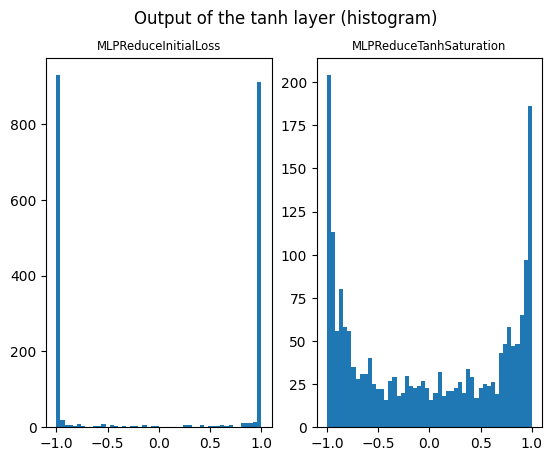

In [137]:
fig, axs = plt.subplots(1, 2)

fig.suptitle('Output of the tanh layer (histogram)')

axs[0].set_title('MLPReduceInitialLoss', fontsize='small')
axs[0].hist(before_h.view(-1), bins=50);
axs[1].set_title('MLPReduceTanhSaturation', fontsize='small')
axs[1].hist(after_h.view(-1), bins=50);

The tanh saturation seems fixed now. Let's see how much this improves our metrics.

100%|██████████| 200000/200000 [00:56<00:00, 3522.33it/s]


tensor(2.1235, grad_fn=<NllLossBackward0>)


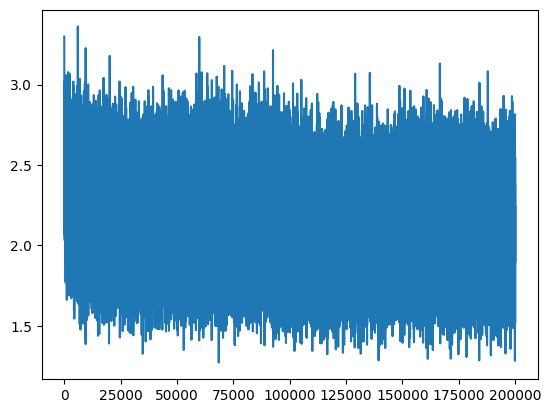

In [138]:
reduce_tanh_sat = MLPReduceTanhSaturation()

training_losses = train_model(reduce_tanh_sat)
dev_loss = eval_model(reduce_tanh_sat)

print(dev_loss)

plt.plot(training_losses);

That improves things quite a bit from our original loss!

In [149]:
import pandas as pd

def eval_to_df(models):
    results = []
    for model in models:
        result = {
            'model': model.__class__.__name__,
            'loss':   eval_model(model),
        }

        results.append(result)
    
    return pd.DataFrame.from_records(results).set_index('model')

eval_to_df([base, reduce_initial_loss, reduce_tanh_sat])


,loss
model,
MLPBase,tensor(15.4808)
MLPReduceInitialLoss,tensor(3.2817)
MLPReduceTanhSaturation,tensor(2.1235)


That improves things quite a bit from our original loss!

These scaling number we're choosing seem a bit arbitrary. Let's try to make them more systematic by using `torch.nn.init.kaiming_normal_` which is based on [this research paper](https://arxiv.org/pdf/1502.01852.pdf).

In [74]:
#| echo: true
#| output: false

class MLPKaimingNormal(MLPReduceInitialLoss):
    """MLPBase is the base class for all the multi layer perceptron
    models we'll try in this post to optimize our network"""

    def __init__(self):
        super().__init__()

        # W1, B1 are parameters for the embedding layer -> hidden layer
        self.W1 = torch.randn((context_size * word_embedding_size, hidden_layer_size), generator=g)
        torch.nn.init.kaiming_normal_(self.W1, nonlinearity='tanh')
        self.B1 = torch.randn((hidden_layer_size,), generator=g) * 0.01

        self.params = [self.C, self.W1, self.B1, self.W2, self.B2,]

        for param in self.params:
            param.requires_grad = True

100%|██████████| 1/1 [00:00<00:00, 951.74it/s]


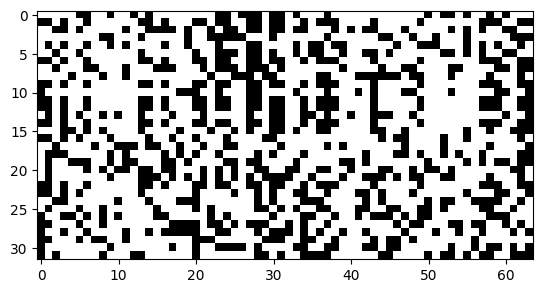

In [76]:
kaiming = MLPKaimingNormal()

train_losses = train_model(kaiming, n_iter=1)

h = kaiming.last_H.data
plt.imshow(h.abs() > 0.99, cmap='Greys');

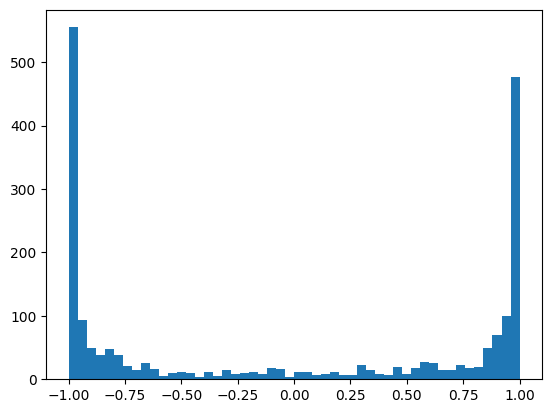

In [78]:
plt.hist(h.view(-1), bins=50);

100%|██████████| 200000/200000 [01:03<00:00, 3158.63it/s]


tensor(2.1296, grad_fn=<NllLossBackward0>)


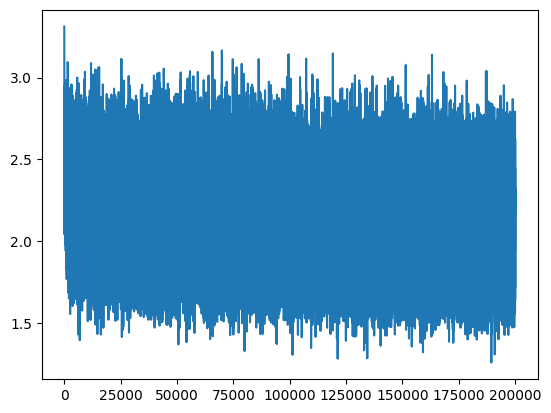

In [79]:
kaiming = MLPKaimingNormal()

train_losses = train_model(kaiming)

dev_loss = eval_model(kaiming)

print(dev_loss)

plt.plot(train_losses)

Kaiming's performance is pretty comparable to manually reducing tanh saturation.

Next, we'll try batch normalization. This idea came from [this paper](https://arxiv.org/pdf/1502.03167.pdf) where instead of trying to cleverly initialize the network to make the input to hidden layers a Gaussian distribution, we force them to be Gaussian in the initial iterations of training and slowly learn over time to become non-Gaussian.

In [96]:
#| echo: true
#| output: false
class MLPBatchNormal(MLPReduceInitialLoss):
    """In MLPBatchNorm, we'll add a batch normalization
    step inside our neural network to force the
    inputs of the hidden layer to be Gaussian
    a lower initial loss

    We'll do this by scaling the initial weights"""

    def __init__(self):
        super().__init__()

        # we don't need a bias anymore 
        self.W1 = torch.randn((context_size * word_embedding_size, hidden_layer_size), generator=g) 
        torch.nn.init.kaiming_normal_(self.W1, nonlinearity='tanh')

        self.bngain = torch.ones((hidden_layer_size, ))
        self.bnbias = torch.zeros((hidden_layer_size, ))

        self.bnmean_running = torch.zeros((hidden_layer_size, ))
        self.bnstd_running = torch.ones((hidden_layer_size, ))

        self.last_bnmean = None
        self.last_bnstd = None

        self.params = [self.C, self.W1, self.bngain, self.bnbias, self.W2, self.B2,]

        for param in self.params:
            param.requires_grad = True

    def __call__(self, X: torch.Tensor, training=False):
        # E is the embedding layer
        # the shape of this is num_examples * context_size * word_embedding_size
        E = self.C[X].view(-1, context_size * word_embedding_size) 

        # H is the hidden layer
        hpreact = E @ self.W1 + self.B1

        if training:
            self.last_bnmean = hpreact.mean(0, keepdim=True)
            self.last_bnstd = hpreact.std(0, keepdim=True)

            hnorm = self.bngain * (hpreact - self.last_bnmean) / self.last_bnstd + self.bnbias
        else:
            hnorm = self.bngain * (hpreact - self.bnmean_running) / self.bnstd_running + self.bnbias


        H = hnorm.tanh()
        self.last_H = H

        # logits from the output layer
        logits = H @ self.W2 + self.B2
        self.last_logits = logits
        return logits
    
    def optim_step(self, lr: float):
        for param in self.params:
            param.data += -lr * param.grad

        with torch.no_grad():
            self.bnmean_running = self.bnmean_running * 0.99 + self.last_bnmean * 0.01
            self.bnstd_running = self.bnstd_running * 0.99 + self.last_bnstd * 0.01



In [91]:
bn = MLPBatchNormal()

dev_losses = train_model(bn)

print(eval_model(bn))

100%|██████████| 200000/200000 [01:29<00:00, 2226.92it/s]


tensor(2.1327, grad_fn=<NllLossBackward0>)


Hmm, this is not quite as good as our manual initialization to fix tanh saturation.

I'm not totally sure why this is, but I want to move on to the pytorch API for these networks. I feel that the Pytorch API might help me visualize the gradients and activations of the networks, which would help me experiment with different architectures more easily.

In [116]:
from torch import nn

class Linear(nn.Linear):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)


C = torch.randn((num_letters, word_embedding_size))

layers = [
    Linear(context_size * word_embedding_size, hidden_layer_size), nn.Tanh(),
    nn.Linear(hidden_layer_size, num_letters)
]

with torch.no_grad():
    # make last layer less confident
    layers[-1].weight *= 0.1

    for layer in layers[:-1]:
        # add a gain to account for non-linearity
        if isinstance(layer, nn.Linear):
            layer.weight *= 5/3
    
params = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in params))

for p in params:
    p.requires_grad = True

TypeError: Linear.__init__() takes 1 positional argument but 3 were given

In [112]:
# training loop

def train_model_torch(C, layers, n_iter=training_iter):
    training_losses = []

    for i in tqdm(range(n_iter)):
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        X = Xtr[ix]
        Y = Ytr[ix]

        # E is the embedding layer
        # the shape of this is num_examples * context_size * word_embedding_size
        E = C[X].view(-1, context_size * word_embedding_size) 

        O = E

        for layer in layers:
            O = layer(O)
        loss = F.cross_entropy(O, Y)

        # for layer in layers:
        #     layer.out.retain_grad()

        for p in params:
            p.grad = None

        loss.backward()
        
        lr = 0.1 if i < n_iter // 2 else 0.01

        for p in params:
            p.data += -lr * p.grad

        training_losses.append(loss.data)
    return training_losses


In [115]:
train_model_torch(C, layers, 1)

100%|██████████| 1/1 [00:00<00:00, 809.71it/s]


[tensor(2.1694)]

In [ ]:
for i, layer in enumerate(layers):
    if isinstance(layer, nn.Tanh):

        

## Generate new words

Let's see what kinds of words our model generates.

In [ ]:
#| echo: true
#| code-fold: true

for i in range(10):
    
    context = [0] * context_size
    word = ''

    while True:
        logits = m(torch.tensor(context))
        # sanity check
        assert logits.shape == (1, num_letters)

        probs = logits.softmax(dim=1)
        # sanity check
        np.testing.assert_almost_equal(probs[0].sum().item(), 1, decimal=3)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        context = context[1:] + [ next_letter_ix ]
    print(word)

I'd say these are half decent. Definitely far from random. Our model did learn something after all.